In [1]:
!pip install tensorflow

In [3]:
import tensorflow as tf
from keras.utils import to_categorical
import keras
import pandas as pd
import numpy as np

In [137]:
df = pd.read_csv('/content/HistoricalData_1758614145330.csv')

In [138]:
df.head()

,Date,Close/Last,Volume,Open,High,Low
0,09/22/2025,$252.53,32290540,$254.43,$255.78,$250.30
1,09/19/2025,$254.72,55571420,$253.25,$256.00,$251.81
2,09/18/2025,$252.03,31239470,$251.68,$253.99,$249.80
3,09/17/2025,$249.53,34107990,$251.22,$251.60,$246.28
4,09/16/2025,$251.16,34109720,$252.08,$253.04,$249.47


In [139]:
df['Close'] = df['Close/Last'].map( lambda x : float(x.replace('$', '')))
df['Date'] = pd.to_datetime(df['Date'])
df.High = df.High.map( lambda x : float(x.replace('$', '')))
df.Open = df.Open.map( lambda x : float(x.replace('$', '')))
df.Low = df.Low.map( lambda x : float(x.replace('$', '')))
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(by='Date', ascending=True)

In [140]:
df.head()

,Date,Close/Last,Volume,Open,High,Low,Close
2513,2015-09-23,$32.6645,29110120,32.6450,33.0140,32.5365,32.6645
2512,2015-09-24,$32.7455,38666860,32.4485,32.8385,32.1082,32.7455
2511,2015-09-25,$32.0075,48425160,32.9290,32.9290,31.9827,32.0075
2510,2015-09-28,$31.2125,47440820,31.9525,32.1425,30.8920,31.2125
2509,2015-09-29,$31.1305,42128220,31.2750,31.7340,30.9015,31.1305


In [141]:
import matplotlib.pyplot as plt

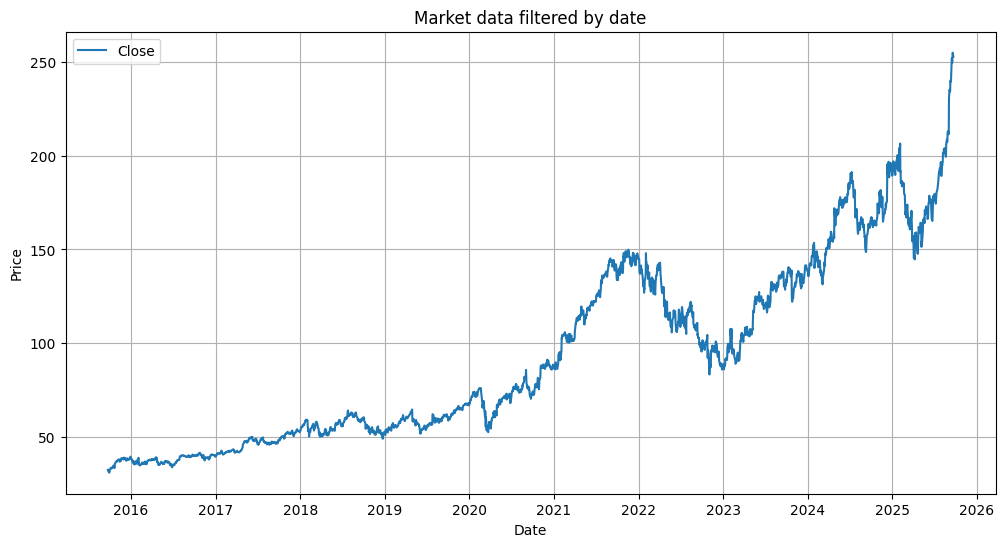

In [142]:
plt.figure(figsize=(12,6))
plt.plot(df["Date"], df["Close"], label="Close")

plt.xlabel("Date")
plt.ylabel("Price")
plt.title("Market data filtered by date")
plt.legend()
plt.grid(True)
plt.show()

In [143]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Conv1D, MaxPooling1D, Dense, Dropout,ConvLSTM1D

In [144]:
feature_cols = ['Open','High','Low','Close','Volume']
target_col = 'Close'
close_index = feature_cols.index(target_col)

In [145]:
scaler = StandardScaler()
data_scaled = scaler.fit_transform(df[feature_cols].values.astype('float32'))

In [146]:
SEQ_LEN = 200
HORIZON_SHORT = 1
HORIZON_LONG = 5
def create_sequences(data_scaled, seq_len=30, horizon=1, target_index=close_index):
    X,y = [],[]
    n = len(data_scaled)
    for i in range(n - seq_len - horizon + 1):
        X.append(data_scaled[i:i+seq_len])
        y_seq = data_scaled[i+seq_len:i+seq_len+horizon, target_index]
        if horizon == 1:
            y.append(y_seq[0])
        else:
            y.append(y_seq)
    return np.array(X), np.array(y)

In [147]:
X_s, y_s = create_sequences(data_scaled, SEQ_LEN, HORIZON_SHORT)
X_l, y_l = create_sequences(data_scaled, SEQ_LEN, HORIZON_LONG)

def time_split(X,y,train_frac=0.7):
    n = len(X)
    split = int(n*train_frac)
    return X[:split], X[split:], y[:split], y[split:]

Xtr_s, Xte_s, ytr_s, yte_s = time_split(X_s,y_s)
Xtr_l, Xte_l, ytr_l, yte_l = time_split(X_l,y_l)

In [148]:
print("Shapes court-terme:", Xtr_s.shape, ytr_s.shape)
print("Shapes long-terme:", Xtr_l.shape, ytr_l.shape)

Shapes court-terme: (1619, 200, 5) (1619,)
Shapes long-terme: (1617, 200, 5) (1617, 5)


In [151]:
def invert_scaling(y_scaled):
    y_scaled = np.array(y_scaled).reshape(-1)
    arr = np.zeros((len(y_scaled), len(feature_cols)))
    arr[:, close_index] = y_scaled
    return scaler.inverse_transform(arr)[:, close_index]

def evaluate_model(model, X_test, y_test, horizon=1, name=""):
    y_pred = model.predict(X_test, verbose=0)

    if horizon == 1:
        # S'assurer que c'est bien 1D
        y_pred = y_pred.reshape(-1)
        y_test = y_test.reshape(-1)
        ytrue = invert_scaling(y_test)
        ypred = invert_scaling(y_pred)
    else:
        # Multi-output : (n_samples, horizon)
        y_pred = np.array(y_pred)
        ytrue = np.column_stack([invert_scaling(y_test[:,i]) for i in range(horizon)])
        ypred = np.column_stack([invert_scaling(y_pred[:,i]) for i in range(horizon)])

    rmse = math.sqrt(np.mean((ypred - ytrue) ** 2))
    mae = np.mean(np.abs(ypred - ytrue))
    print(f"{name} -> RMSE={rmse:.4f}, MAE={mae:.4f}")
    return ytrue, ypred, rmse, mae


In [154]:
def build_lstm(input_shape, horizon=1):
    model = Sequential([
        LSTM(128, return_sequences=False, input_shape=input_shape),
        Dropout(0.2),
        Dense(64),
        Dropout(0.2),
        Dense(32),
        Dropout(0.2),
        Dense(horizon)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_gru(input_shape, horizon=1):
    model = Sequential([
        GRU(128, return_sequences=False, input_shape=input_shape),
        Dropout(0.2),
        Dense(64),
        Dropout(0.2),
        Dense(32),
        Dropout(0.2),
        Dense(horizon)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

def build_conv1d_lstm(input_shape, horizon=1):
    model = Sequential([
        Conv1D(64, kernel_size=3, activation='relu', input_shape=input_shape),
        MaxPooling1D(pool_size=2),
        Dense(128),
        Dropout(0.2),
        Dense(64),
        Dropout(0.2),
        Dense(horizon)
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



--- Training LSTM (1-step) ---
Epoch 1/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.1723 - val_loss: 0.0498
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0169 - val_loss: 0.0427
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0137 - val_loss: 0.0242
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0120 - val_loss: 0.0262
Epoch 5/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0101 - val_loss: 0.0324
Epoch 6/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0099 - val_loss: 0.0292
Epoch 7/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0093 - val_loss: 0.0232
Epoch 8/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0078 - val_loss: 0.0241
Epoch 9/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0074 - val_loss: 0.0269
Epoch 10/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0085 - val_loss: 0.0559
Epoch 11/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0085 - val_loss: 0.0109
Epoch 12/20
51/51 ━━━━━━━━━━━━━

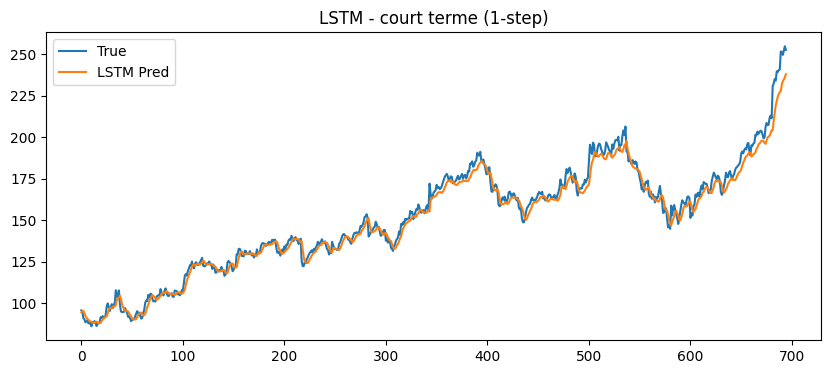


--- Training GRU (1-step) ---
Epoch 1/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - loss: 0.1513 - val_loss: 0.0185
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0154 - val_loss: 0.0104
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0124 - val_loss: 0.0139
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0111 - val_loss: 0.0162
Epoch 5/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0118 - val_loss: 0.0142
Epoch 6/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0085 - val_loss: 0.0085
Epoch 7/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0086 - val_loss: 0.0159
Epoch 8/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0082 - val_loss: 0.0076
Epoch 9/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0083 - val_loss: 0.0258
Epoch 10/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0080 - val_loss: 0.0178
Epoch 11/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0075 - val_loss: 0.0078
Epoch 12/20
51/51 ━━━━━━━━━━━━━━

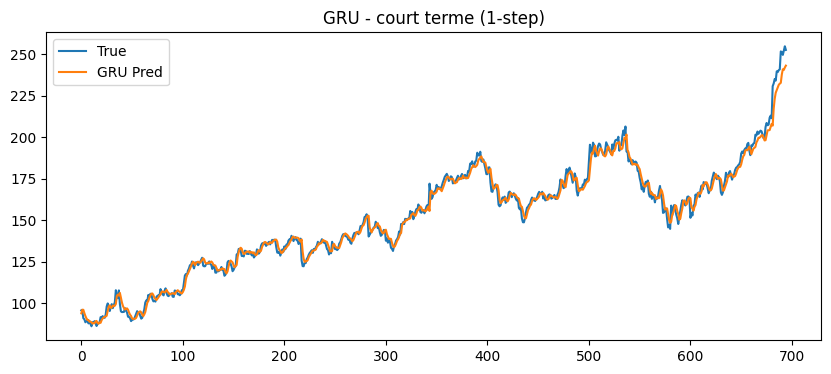


--- Training Conv1D+LSTM (1-step) ---
Epoch 1/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 7s 44ms/step - loss: 0.4946 - val_loss: 3.0320
Epoch 2/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4592 - val_loss: 3.2360
Epoch 3/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4489 - val_loss: 3.0011
Epoch 4/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4391 - val_loss: 2.8639
Epoch 5/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4294 - val_loss: 2.8010
Epoch 6/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4312 - val_loss: 2.8581
Epoch 7/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4509 - val_loss: 2.7647
Epoch 8/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4380 - val_loss: 2.5599
Epoch 9/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4313 - val_loss: 2.4589
Epoch 10/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4208 - val_loss: 2.6206
Epoch 11/20
51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4332 - val_loss: 2.6980
Epoch 12/20
51/51 ━━━━━━━━━━━━━━━━

ValueError: operands could not be broadcast together with shapes (68805,) (695,) 

In [153]:
input_shape = (SEQ_LEN, len(feature_cols))

models = {
    "LSTM": build_lstm(input_shape, horizon=1),
    "GRU": build_gru(input_shape, horizon=1),
    "Conv1D+LSTM": build_conv1d_lstm(input_shape, horizon=1),
}

results = []
for name, model in models.items():
    print(f"\n--- Training {name} (1-step) ---")
    model.fit(Xtr_s, ytr_s, validation_data=(Xte_s, yte_s), epochs=20, batch_size=32, verbose=1)
    ytrue, ypred, rmse, mae = evaluate_model(model, Xte_s, yte_s, horizon=1, name=name)
    results.append((name, rmse, mae))
    # plot
    plt.figure(figsize=(10,4))
    plt.plot(ytrue, label="True")
    plt.plot(ypred, label=f"{name} Pred")
    plt.title(f"{name} - court terme (1-step)")
    plt.legend()
    plt.show()


--- Multi-jours (5steps) ---
Epoch 1/20


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


26/26 ━━━━━━━━━━━━━━━━━━━━ 3s 29ms/step - loss: 0.3262 - val_loss: 0.1021
Epoch 2/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0676 - val_loss: 0.0670
Epoch 3/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0508 - val_loss: 0.0230
Epoch 4/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0445 - val_loss: 0.0488
Epoch 5/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0403 - val_loss: 0.0400
Epoch 6/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0362 - val_loss: 0.0268
Epoch 7/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0333 - val_loss: 0.0354
Epoch 8/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0314 - val_loss: 0.0211
Epoch 9/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0276 - val_loss: 0.0149
Epoch 10/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0276 - val_loss: 0.0269
Epoch 11/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - loss: 0.0280 - val_loss: 0.0214
Epoch 12/20
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - loss: 0.0238 - val_l

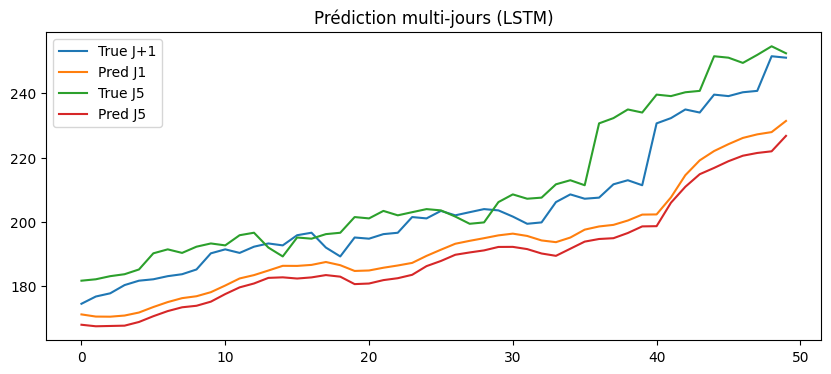

In [158]:
print("\n--- Multi-jours ("+ str(HORIZON_LONG) +"steps) ---")
multi_model = build_lstm(input_shape, horizon=HORIZON_LONG)
multi_model.fit(Xtr_l, ytr_l, validation_data=(Xte_l, yte_l), epochs=20, batch_size=64, verbose=1)
ytrue_l, ypred_l, rmse_l, mae_l = evaluate_model(multi_model, Xte_l, yte_l, horizon=HORIZON_LONG, name="LSTM-multi")

# plot prédictions multi-jours
plt.figure(figsize=(10,4))
plt.plot(ytrue_l[-50:,0], label="True J+"+str(HORIZON_SHORT))
plt.plot(ypred_l[-50:,0], label="Pred J"+str(HORIZON_SHORT))
plt.plot(ytrue_l[-50:,4], label="True J"+str(HORIZON_LONG))
plt.plot(ypred_l[-50:,4], label="Pred J"+str(HORIZON_LONG))
plt.title("Prédiction multi-jours (LSTM)")
plt.legend()
plt.show()